## Model choice

In this project, we have two constraints : training time and model accuracy. To have the best compromise between performance and speed in training, we chose the AlBERT model (Lan et al. 2019) which has similar benchmark results as BERT but with interesting parameter-reduction techniques which lower memory consumption and increase the training speed.

Note that we tried to use the albert-base-v2, but had worse performances than albert-base-v1. We also increased the dropout probability and the weight decay of the optimizer to reduce the overfitting we experienced during training.

## Imports

In [34]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [35]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import transformers
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer
from transformers import AlbertForSequenceClassification, AlbertConfig, AlbertTokenizer
from bertviz import model_view, head_view
from torch.utils.tensorboard import SummaryWriter

## Data Preparation

In [36]:
## DATA LOADING

from datasets import load_dataset
snli = load_dataset("snli")
#Removing sentence pairs with no label (-1)
snli = snli.filter(lambda example: example['label'] != -1) 

Reusing dataset snli (/usr/users/gpusdi1/gpusdi1_52/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_52/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-69916534c8046ad9.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_52/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-3eb05855f5b61765.arrow
Loading cached processed dataset at /usr/users/gpusdi1/gpusdi1_52/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-48d9b7dcd4658c32.arrow


In [37]:
## LOOKING AT DATA

print('Dataset keys = ', snli.keys(), '\n')

n_examples = 6
print(f'First {n_examples} train examples =')
for i in range(n_examples):
    print(snli['train'][i]['premise'], '-', snli['train'][i]['hypothesis'], '-', snli['train'][i]['label'])

Dataset keys =  dict_keys(['test', 'train', 'validation']) 

First 6 train examples =
A person on a horse jumps over a broken down airplane. - A person is training his horse for a competition. - 1
A person on a horse jumps over a broken down airplane. - A person is at a diner, ordering an omelette. - 2
A person on a horse jumps over a broken down airplane. - A person is outdoors, on a horse. - 0
Children smiling and waving at camera - They are smiling at their parents - 1
Children smiling and waving at camera - There are children present - 0
Children smiling and waving at camera - The kids are frowning - 2


It may be interesting to look at labels distribution to check that we are not in an imbalanced setting.

In [38]:
## LABEL DISTRIBUTION

def label_distribution(data):
    counter = Counter(data)
    n_data = sum(counter.values())
    for k, v in counter.items():
        counter[k] = round(v/n_data, 4)
    print(counter)
    return counter

print('Train labels distribution =')
train_counter = label_distribution(snli['train']['label'])
print('Validation labels distribution =')
valid_counter = label_distribution(snli['validation']['label'])
print('Test labels distribution =')
test_counter = label_distribution(snli['test']['label'])

Train labels distribution =
Counter({0: 0.3339, 2: 0.3335, 1: 0.3327})
Validation labels distribution =
Counter({0: 0.3382, 2: 0.3331, 1: 0.3287})
Test labels distribution =
Counter({0: 0.3428, 2: 0.3295, 1: 0.3277})


The classes are perfectly balanced.

In [39]:
## TOKENIZER DEFINITION

def get_tokenizer(model_tokenizer=AlbertTokenizer, model_name="albert-base-v1"):
    
    tokenizer = model_tokenizer.from_pretrained(model_name)
    n_tokens = 50 # number of tokens to display
    print(f'First {n_tokens} tokens = {list(tokenizer.get_vocab().keys())[:n_tokens]}')
    print(f'Vocab size of {model_name} ={tokenizer.vocab_size}')
    return tokenizer

tokenizer = get_tokenizer()

First 50 tokens = ['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]', '(', ')', '"', '-', '.', '–', '£', '€', '▁', '▁the', ',', '▁of', '▁and', 's', '▁in', '▁to', '▁a', "'", '▁was', '▁he', '▁is', '▁for', '▁on', '▁as', '▁with', '▁that', '▁i', '▁it', '▁his', '▁by', '▁at', '▁her', '▁from', 't', '▁she', '▁an', '▁had', '▁you', 'd', '▁be', ':', '▁were', '▁but', '▁this', 'i']
Vocab size of albert-base-v1 =30000


The tokenizer outputs 3 tensor from a given pair of sentences: 
- The input_ids: the index of the token in the vocab.
- The token_type_ids: which sentence the token belongs to.
- The attention_mask: to detect padding.

In [40]:
## TEST TOKENIZER

def test_tokenizer(tokenizer, text_a, text_b):
    
    tokenized_text = tokenizer(text_a, text_b, padding='max_length', max_length=20, 
                               truncation=True, return_tensors="pt")
    print('Tokenized:')
    print(tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0]), '\n')
    print('Input_ids:')
    print(tokenized_text['input_ids'][0], '\n')
    print('Token_type_ids:')
    print(tokenized_text['token_type_ids'][0], '\n')
    print('Attention_mask')
    print(tokenized_text['attention_mask'][0], '\n')
    
test_tokenizer(tokenizer, "Hello people", "the cat didn't sit on the mat")

Tokenized:
['[CLS]', '▁hello', '▁people', '[SEP]', '▁the', '▁cat', '▁didn', "'", 't', '▁sit', '▁on', '▁the', '▁mat', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 

Input_ids:
tensor([    2, 10975,   148,     3,    14,  2008,   223,    22,    38,  2066,
           27,    14,  4277,     3,     0,     0,     0,     0,     0,     0]) 

Token_type_ids:
tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]) 

Attention_mask
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]) 



In [41]:
## DATA ENCODING AND PREPARATION

def encode(tokenizer, data):
    # this function encodes each (premise, hypothesis) pair
    return tokenizer(data['premise'], data['hypothesis'])

def tokenize_data(tokenizer, data):
    # this function prepares columns and their names as accepted by the hugging face models
    data = data.map(lambda examples: encode(tokenizer, examples), batched=True)
    data = data.map(lambda examples: {'labels': examples['label']}, batched=True)
    data.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return data

def prepare_dataloader(data, batch_size):
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    return loader

For the encoding using the tokenizer, we wanted to choose a max_length value that is small enough to allow large batch sizes, but also large enough to avoid truncation.
We started by tokenizing with no padding and no truncation to extract the true lengths.
We can visualize tokenized inputs lengths distribution in order to choose a max_length to faster the training.

In [42]:
if not os.path.exists('./data'):
    os.mkdir('./data')

In [43]:
def tokenize_save_data_raw(tokenizer, data, filepath):
    train_data = tokenize_data(tokenizer, snli['train'])
    valid_data = tokenize_data(tokenizer, snli['validation'])
    test_data = tokenize_data(tokenizer, snli['test'])
    with open(filepath, 'wb') as f:
        pickle.dump({'train': train_data, 'validation': valid_data, 'test': test_data}, f)
        
#tokenize_save_data_raw(tokenizer, data, './data/snli_tokenized_raw.pkl')

100%|██████████████████████████████| 549367/549367 [00:00<00:00, 1623297.39it/s]


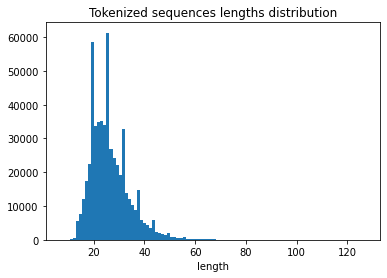

In [44]:
d = pd.read_pickle(open("./data/snli_tokenized_raw.pkl", "rb"))['train']
lengths = []
for t in tqdm(d['input_ids']):
    lengths.append(t.size()[0])
plt.hist(lengths, bins=100)
plt.xlabel('length')
plt.title('Tokenized sequences lengths distribution')
plt.show()

From the distribution, we chose max_length = 45. With such a value, not a lot of samples will be truncated.

In [45]:
## REDEFINE THE ENCODING FUNCTION TO ADD CHOSEN PARAMS

def encode(tokenizer, data):
    # we add max_length of 45 and activate truncation
    return tokenizer(data['premise'], data['hypothesis'], truncation=True, padding='max_length', max_length=45)

#tokenize_save_data_raw(tokenizer, data, './data/snli_tokenized.pkl')

The data is already prepared and saved.
Now we define a batch size and create the dataloaders.

In [46]:
batch_size = 128

In [47]:
train_loader = prepare_dataloader(pd.read_pickle(open("./data/snli_tokenized.pkl", "rb"))['train'], 
                                 batch_size)
print(f'Number of train samples = {len(train_loader.dataset)}')
print(f'Number of train batches = {len(train_loader)}')

Number of train samples = 549367
Number of train batches = 4292


In [48]:
valid_loader = prepare_dataloader(pd.read_pickle(open("./data/snli_tokenized.pkl", "rb"))['validation'],
                                 batch_size)
print(f'Number of validation samples = {len(valid_loader.dataset)}')
print(f'Number of validation batches = {len(valid_loader)}')

Number of validation samples = 9842
Number of validation batches = 77


In [49]:
test_loader = prepare_dataloader(pd.read_pickle(open("./data/snli_tokenized.pkl", "rb"))['test'],
                                batch_size)
print(f'Number of test samples = {len(test_loader.dataset)}')
print(f'Number of test batches = {len(test_loader)}')

Number of test samples = 9824
Number of test batches = 77


## Model Definition

In this section we define the model, the optimization and visualization tools, as well as the checkpoints.

In [50]:
## LOAD THE PRETRAINED MODEL AND CREATE A MODEL

def create_model(model_bert=AlbertForSequenceClassification, model_name="albert-base-v1"):
    # load the model
    model = model_bert.from_pretrained(model_name, num_labels=3, output_attentions=True)
    # we can choose to freeze the parameters except the classifier layer
    '''
    for param in model.albert.parameters():
        param.requires_grad = False
    '''
    # increase the dropout to dimish overfitting
    model.dropout = nn.Dropout(p=0.5)
    return model

Since this is classification problem, we can monitor both the accuracy and the f1 score.

In [51]:
def compute_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='macro')
    return accuracy, f1

We used early stopping by only saving the best model when monitoring the validation accuracy. The checkpoint class saves this model.

In [52]:
class ModelCheckpoint():
    
    def __init__(self, experiment_tag):
        self.filepath = os.path.join(models_directory, experiment_tag+'_best_model.pt')
        self.max_accuracy = None
    
    def update(self, accuracy, model):
        if (self.max_accuracy is None) or (accuracy > self.max_accuracy):
            self.max_accuracy = accuracy
            torch.save(model.state_dict(), self.filepath)

We will save our metrics in a tensorboard for better visualization.

In [53]:
def update_tensorboard(writer, epoch, 
                      train_loss, valid_loss,
                      train_acc, valid_acc,
                      train_f1, valid_f1):
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/validation', valid_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/valid', valid_acc, epoch)
    writer.add_scalar('F1/train', train_f1, epoch)
    writer.add_scalar('F1/valid', valid_f1, epoch)
    return

Next we define the train and validation functions per epoch.

In [54]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    
    model.train()
    total_loss = []
    true_labels, pred_labels = [], []
    
    for i, batch in enumerate(tqdm(train_loader)):
        
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch).logits
        
        labels = batch['labels']
        loss = criterion(outputs, labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
        true_labels.append(labels)
        pred_labels.append(torch.argmax(outputs, dim=1))
    
    true_labels = torch.cat(true_labels).to('cpu').detach().numpy()
    pred_labels = torch.cat(pred_labels).to('cpu').detach().numpy()
    
    total_loss = np.mean(total_loss)
    accuracy, f1 = compute_metrics(true_labels, pred_labels)
    print(f'-- train loss {total_loss:.4f} train accuracy {accuracy:.4f} train F1 {f1:.4f}')
    
    return total_loss, accuracy, f1


def valid_epoch(model, valid_loader, criterion, device):
    
    model.eval()
    
    with torch.no_grad():
        
        total_loss = []
        true_labels, pred_labels = [], []
        
        for i, batch in enumerate(tqdm(valid_loader)):
            
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch).logits
            
            labels = batch['labels']
            loss = criterion(outputs, labels.long())
            
            total_loss.append(loss.item())
            true_labels.append(labels)
            pred_labels.append(torch.argmax(outputs, dim=1))
        
        true_labels = torch.cat(true_labels).to('cpu').detach().numpy()
        pred_labels = torch.cat(pred_labels).to('cpu').detach().numpy()
    
        total_loss = np.mean(total_loss)
        accuracy, f1 = compute_metrics(true_labels, pred_labels)
        print(f'-- valid loss {total_loss:.4f} valid accuracy {accuracy:.4f} valid F1 {f1:.4f}')
        
    return total_loss, accuracy, f1

In [55]:
## DEFINE DEVICE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [56]:
## CREATE MODEL

model = create_model().to(device)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The number of trainable parameters = {num_trainable_params}')
print(model)

Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

The number of trainable parameters = 11685891
AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (v

We used the cross entropy loss because we have a multilabel classfication problem and the model outputs the logits. For the optimizer, we first tried SGD but the performances weren't great, so we switched to an adaptative version and chose AdamW for its generalization capacities.

In [57]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4, weight_decay=0.1)

In [58]:
## DEFINE NUMBER OF EPOCHS

nepochs = 10

## ASSIGN A TAG

experiment_tag = 'albert_maxlen45_bs128_unfreezed_reg'

## DEFINE A SAVING DIRECTORY

models_directory = './models'
if not os.path.exists(models_directory):
    os.mkdir(models_directory)

## DEFINE A TENSORBOARD

tensorboard_logdir = os.path.join('./tensorboard_history', experiment_tag)
if not os.path.exists('./tensorboard_history'):
    os.mkdir('./tensorboard_history')
if not os.path.exists(tensorboard_logdir):
    os.mkdir(tensorboard_logdir)
writer = SummaryWriter(tensorboard_logdir)

## DEFINE A CHECKPOINT OBJECT

model_ckpt = ModelCheckpoint(experiment_tag)

Now as we have defined all our tools we can proceed with training.
We trained our model using a ".py" file because of the limited time of the interactive session.

In [59]:
## TRAINING LOOP

for epoch in range(nepochs):
    print(f'Epoch {epoch} ... ')
    continue  # comment if you want to train here
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, valid_f1 = valid_epoch(model, valid_loader, criterion, device)
    model_ckpt.update(valid_loss, model)
    update_tensorboard(writer, epoch, 
                      train_loss, valid_loss,
                      train_acc, valid_acc,
                      train_f1, valid_f1)

Epoch 0 ... 
Epoch 1 ... 
Epoch 2 ... 
Epoch 3 ... 
Epoch 4 ... 
Epoch 5 ... 
Epoch 6 ... 
Epoch 7 ... 
Epoch 8 ... 
Epoch 9 ... 


Here is a picture of our output:

<img title="logs" src="results\metrics.PNG">

Our model has good performances, but still suffers from some overfitting.

<img title="accuracy" src="results\accuracy.PNG">
<img title="f1 score" src="results\f1.PNG">
<img title="loss" src="results\loss.PNG">

## Test and Inference

In this section, we test our model on unseen test data and we play with it!

In [60]:
## LOAD THE TRAINED MODEL

model = create_model()
model.load_state_dict(torch.load('./models/albert_maxlen45_bs128_unfreezed_reg_best_model.pt'))
model.to(device)

Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=76

For the test data, we also tried to visualize the confusion matrix.

In [61]:
def test_model(model, test_loader, criterion, device):
    
    model.eval()
    
    with torch.no_grad():
        
        total_loss = []
        true_labels, pred_labels = [], []
        
        for i, batch in enumerate(tqdm(test_loader)):
            
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch).logits
            
            labels = batch['labels']
            loss = criterion(outputs, labels.long())
            
            total_loss.append(loss.item())
            true_labels.append(labels)
            pred_labels.append(torch.argmax(outputs, dim=1))
        
        true_labels = torch.cat(true_labels).to('cpu').detach().numpy()
        pred_labels = torch.cat(pred_labels).to('cpu').detach().numpy()
    
        total_loss = np.mean(total_loss)
        accuracy, f1 = compute_metrics(true_labels, pred_labels)
        print(f'-- test loss {total_loss:.4f} test accuracy {accuracy:.4f} test F1 {f1:.4f}')
        cm = confusion_matrix(true_labels, pred_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

100%|███████████████████████████████████████████| 77/77 [00:21<00:00,  3.65it/s]


-- test loss 0.3163 test accuracy 0.8820 test F1 0.8816


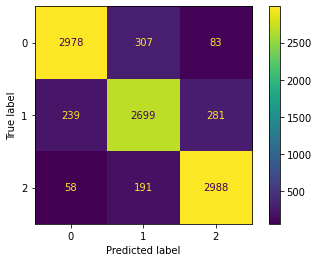

In [62]:
test_model(model, test_loader, criterion, device)

The diagonal of our confusion matrix has the largest number of samples: our model's performance is quite good!

Here we tried to allow the user to check the classes for hiw own sentences. We can also visualize the learned attention between the given sentences.

In [63]:
## PREDICTION FUNCTION

def predict(tokenizer, model, premise, hypothesis, device):
    
    model.eval()
    label_names = {0:'entailed', 1:'neutral', 2:'contradicted'}
    tokenized = tokenizer(premise, hypothesis, return_tensors="pt")
    model_output = model(tokenized['input_ids'].to(device), 
                         tokenized['attention_mask'].to(device), 
                         tokenized['token_type_ids'].to(device))
    output = model_output.logits[0].to('cpu').detach().numpy()
    label = np.argmax(output) # extract the class
    
    attention = model_output[-1] # attention is a tuple containing 12 attention tensors (1 for each layer)
                                 # each tensor is of shape (1, 12, seqlen, seqlen) (12 here is the number of heads)
    
    tokens = tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
    #model_view(attention, tokens)
    head_view(attention, tokens, layer=11) # view attention for last layer
    
    print(f'The sentences "{premise}" and "{hypothesis}" are {label_names[label]} (label = {label})!')

If we have used another model like Bert or DistillBert, the attentions will get better with each layer. In Albert, the parameter sharing through layers makes it more difficult to view beautiful attentions with layers.
You can select a specific head using the colored squares.

In [64]:
contradicted = ['the weather is beautiful! yay.', 
                'it is raining...']
predict(tokenizer, model, contradicted[0], contradicted[1], device)

<IPython.core.display.Javascript object>

The sentences "the weather is beautiful! yay." and "it is raining..." are contradicted (label = 2)!


In [65]:
neutral = ['we are going to the cinema /', 
           'the glass is empty ?']
predict(tokenizer, model, neutral[0], neutral[1], device)

<IPython.core.display.Javascript object>

The sentences "we are going to the cinema /" and "the glass is empty ?" are neutral (label = 1)!


In [66]:
entailed = ['An old man with a package poses in front of an advertisement.', 
            'A man poses in front of an ad!']
predict(tokenizer, model, entailed[0], entailed[1], device)

<IPython.core.display.Javascript object>

The sentences "An old man with a package poses in front of an advertisement." and "A man poses in front of an ad!" are entailed (label = 0)!
